In [1]:
import pandas as pd
import numpy as np
from numpy.random import choice
from scipy.ndimage.interpolation import shift
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier 
from sklearn.metrics import precision_score, accuracy_score, classification_report, log_loss
from sklearn.calibration import CalibratedClassifierCV
from time import time
from sklearn import cross_validation
from sklearn import preprocessing

# 1. Part: Classification with original data

## Import Data (Kaggle OTTO challenge, UNSAMPLED)

In [2]:
x_total = pd.read_csv('./train.csv')
y_total = x_total.target.values

In [3]:
x_class2 = x_total.copy()
x_class3 = x_total.copy()
x_class4 = x_total.copy()

## Relabeling for single partitions
[**Explanation**]: Each new estimator is a OvR classifier and needs a modified training set. Relabeling a dataframe in Python Pandas is most efficiently done via the **lambda** operator, that is a pythonic way of applying functional programming within Python. (_add source here_)  

E.g. Estimator for class 2 is trained on a dataset with target values in ['Class_2, 'Not_Class_2']

In [4]:
x_class2.target= x_class2.target.map(lambda x: x if x=='Class_2' else 'Not_2')
x_class3.target= x_class3.target.map(lambda x: x if x=='Class_3' else 'Not_3')
x_class4.target= x_class4.target.map(lambda x: x if x=='Class_4' else 'Not_4')

#if class 1,5,6,7,8,9, then leave it x, else label it "unknown"
x_total.target = x_total.target.map(lambda x: 'other' if (x=='Class_2') or (x=='Class_3') or (x=='Class_4') else x)

## Create Labelencoder for encode / uncode of labels of last estimator

### check if labelencoder really needed (farbe hier ändern)

In [5]:
le_y_test = preprocessing.LabelEncoder() #create an encoder
 #fit the encoder to y_total
#y_total_coded = le_y_test.transform(y_total)
#list(le_y_test.classes_) #list the classes

#le_y_test.transform(y_total) #transform to numeric labels

#list(le_y_test.inverse_transform(y_total)) #transform back

## prepare 4 seperate datasets (incl. 1 total one), use custom LabelEncoder()

In [6]:
x_total = x_total.drop('id', axis=1)
x_class2 = x_class2.drop('id', axis=1)
x_class3 = x_class3.drop('id', axis=1)
x_class4 = x_class4.drop('id', axis=1)

In [7]:
y_total = x_total.target.values
#encode labels
le_y_test.fit(y_total)
y_total = le_y_test.transform(y_total)

x_total = x_total.drop('target', axis=1)

In [8]:
y_class2 = x_class2.target.values
y_class2 = LabelEncoder().fit_transform(y_class2)
x_class2 = x_class2.drop('target', axis=1)

In [9]:
y_class3 = x_class3.target.values
y_class3 = LabelEncoder().fit_transform(y_class3)
x_class3 = x_class3.drop('target', axis=1)

In [10]:
y_class4 = x_class4.target.values
y_class4 = LabelEncoder().fit_transform(y_class4)
x_class4 = x_class4.drop('target', axis=1)

In [11]:
le_y_test.inverse_transform(y_total[31222])

'Class_5'

In [12]:
y_total[31222]

1

## Split Train / Test separately
[**Explanation**]: We want to completely isolate a 30 % sample of traindata,
so we can afterwards use it for testing and validating.

In [13]:
Xtrain_total, Xtest_total, ytrain_total, ytest_total = train_test_split(x_total, y_total, test_size=0.30, random_state=36)
Xtrain_class2, Xtest_class2, ytrain_class2, ytest_class2 = train_test_split(x_class2, y_class2, test_size=0.30, random_state=36)
Xtrain_class3, Xtest_class3, ytrain_class3, ytest_class3 = train_test_split(x_class3, y_class3, test_size=0.30, random_state=36)
Xtrain_class4, Xtest_class4, ytrain_class4, ytest_class4 = train_test_split(x_class4, y_class4, test_size=0.30, random_state=36)

## Reindexing Xtest_total into new df , needs to be done with ytest as well to be comparable
[**Explanation**]: We need a separate unmodified train/test dataset, that has all 9 original class labels.

This needed for testing/evaluating the final stack_estimator. The labels and corresponding test observations need to be within the original class labels (Class_1 to 9). The above splits are already modified though.

In [14]:
x_final = pd.read_csv('./train.csv')
y_final = x_final.target.values

le_yfinal = preprocessing.LabelEncoder()
le_yfinal.fit(y_final)
y_final = le_yfinal.transform(y_final)

x_final = x_final.drop('target', axis=1)
x_final = x_final.drop('id', axis=1)


Xtrain_final, Xtest_final, ytrain_final, ytest_final = train_test_split(x_final, y_final, test_size=0.30, random_state=36)

In [15]:
le_y_test.classes_

array(['Class_1', 'Class_5', 'Class_6', 'Class_7', 'Class_8', 'Class_9',
       'other'], dtype=object)

In [16]:
Xtest_index = Xtest_final.copy()

Xtest_index.index = range(1,len(Xtest_index) + 1)

#reindex encoded y too ? -> probably not needed.
#y_test_total_encoded = le_y_test.transform(y_test_total_encoded)
#y_tottest_index = y_test_total_encoded

## OvR 4 Estimators for class 2-4 and 1,5-9
[**Explanation**]: (see Confusion Matrix). We found out, that Classes 2-4 are very similar, such that they are being misclassified often to each other, e.g. Class 2 gets many FPs as Class 3. We decided to approach this issue by defining seperate OneVsRest Classifiers for those classes. Each estimator is cross-validated to get a more reliable prediction score.

In [17]:
cv1 = cross_validation.KFold(Xtrain_class2.shape[0], n_folds=5, shuffle=True)
for train_indices, test_indices in cv1:
    print('Train: %s | test: %s' % (train_indices, test_indices))
rf1 = RandomForestClassifier(n_estimators=500, n_jobs=-1, criterion="entropy", min_samples_split=3, 
                             min_samples_leaf=2, bootstrap=True, max_depth = None, class_weight = None, max_features = 30)

[rf1.fit(Xtrain_class2, ytrain_class2).score(Xtest_class2, ytest_class2)
         for train, test in cv1]

Train: [    0     1     2 ..., 43309 43310 43313] | test: [   11    12    13 ..., 43308 43311 43312]
Train: [    0     1     2 ..., 43311 43312 43313] | test: [    7     9    10 ..., 43301 43306 43309]
Train: [    0     1     2 ..., 43309 43311 43312] | test: [    5     6    15 ..., 43307 43310 43313]
Train: [    1     4     5 ..., 43311 43312 43313] | test: [    0     2     3 ..., 43295 43298 43303]
Train: [    0     2     3 ..., 43311 43312 43313] | test: [    1     4    18 ..., 43293 43299 43302]


[0.88957121310062481,
 0.88994828700711048,
 0.89070243482008193,
 0.8904330963154492,
 0.89064856711915541]

RandomizedSearchCV took 1033.68 seconds for 30 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.884 (std: 0.003)
Parameters: {'n_estimators': 500, 'criterion': 'entropy', 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_depth': None, 'class_weight': None, 'max_features': 30}

Model with rank: 2
Mean validation score: 0.882 (std: 0.003)
Parameters: {'n_estimators': 500, 'criterion': 'entropy', 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': True, 'max_depth': None, 'class_weight': None, 'max_features': 30}

Model with rank: 3
Mean validation score: 0.876 (std: 0.005)
Parameters: {'n_estimators': 500, 'criterion': 'entropy', 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True, 'max_depth': None, 'class_weight': 'auto', 'max_features': 10}

In [27]:
cv2 = ShuffleSplit(Xtrain_class3.shape[0], n_iter=10, test_size=0.2, random_state=0)
rf2 = RandomForestClassifier(n_estimators=500, n_jobs=-1, criterion="entropy", bootstrap=False, min_samples_split=10,
                            min_samples_leaf=3, max_depth=None, class_weight=None)
rf2.fit(Xtrain_class3,ytrain_class3)
rf2.score(Xtest_class3,ytest_class3)

0.89980607627666453

RandomizedSearchCV took 974.68 seconds for 30 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.894 (std: 0.001)
Parameters: {'criterion': 'entropy', 'n_estimators': 100, 'bootstrap': True, 'min_samples_split': 10, 'max_features': 10, 'min_samples_leaf': 2, 'max_depth': None, 'class_weight': None}

Model with rank: 2
Mean validation score: 0.894 (std: 0.001)
Parameters: {'criterion': 'entropy', 'n_estimators': 100, 'bootstrap': True, 'min_samples_split': 10, 'max_features': 10, 'min_samples_leaf': 3, 'max_depth': None, 'class_weight': None}

Model with rank: 3
Mean validation score: 0.893 (std: 0.002)
Parameters: {'criterion': 'gini', 'n_estimators': 200, 'bootstrap': False, 'min_samples_split': 10, 'max_features': 30, 'min_samples_leaf': 15, 'max_depth': None, 'class_weight': None}

In [30]:
cv3 = ShuffleSplit(Xtrain_class4.shape[0], n_iter=10, test_size=0.2, random_state=0)
rf3 = RandomForestClassifier(n_estimators=500, max_features="sqrt", criterion="gini", bootstrap=False,
                                min_samples_leaf=1, min_samples_split=3, max_depth= None, class_weight="subsample",
                                n_jobs=-1)
rf3.fit(Xtrain_class4,ytrain_class4)
rf3.score(Xtest_class4,ytest_class4)

0.96837965955613015

In [32]:
cv_all = cross_validation.KFold(Xtrain_total.shape[0], n_folds=5, shuffle=True)
for train_indices, test_indices in cv_all:
    print('Train: %s | test: %s' % (train_indices, test_indices))
rf_all = RandomForestClassifier(n_estimators=500, max_features="sqrt", criterion="gini", bootstrap=False,
                                min_samples_leaf=1, min_samples_split=3, max_depth= None, class_weight="auto",
                                n_jobs=-1)
[rf_all.fit(Xtrain_total, ytrain_total).score(Xtest_total, ytest_total)
         for train, test in cv_all]

Train: [    0     1     2 ..., 43310 43311 43312] | test: [   12    21    24 ..., 43306 43309 43313]
Train: [    0     2     3 ..., 43311 43312 43313] | test: [    1     8    10 ..., 43293 43301 43307]
Train: [    0     1     3 ..., 43310 43312 43313] | test: [    2    22    31 ..., 43300 43308 43311]
Train: [    0     1     2 ..., 43309 43311 43313] | test: [    4     5     6 ..., 43304 43310 43312]
Train: [    1     2     4 ..., 43311 43312 43313] | test: [    0     3     7 ..., 43283 43285 43298]


[0.92614738202973501,
 0.9270092652445594,
 0.92684766214177983,
 0.92695539754363288,
 0.92690152984270635]

## prediction errors of each classifiers as weights for stack_estimate
[**Explanation**]: The rf_all estimator in last branch of stack_estimate() is the last instance and should ideally classify to classes 1,5,6,7,8,9. But sometimes the classifier finds a class, that should have been caught up earlier by the other estimators for classes 2,3,4. In that case, the last branch has to decide, wich class to choose.

The prediction errors can be used as weights. This means, the class estimator with the highest prediction error will be chosen more often by random choice, because it is more likely, that this estimator was wrong in first place and did not recognize 'his' class. Thus estimators with higher error rate get _"penalized"_.

The prediction errors need to be normalized and sum up to 1. 

In [33]:
#single score of rf1
weight_cl2 = 1 - rf1.score(Xtest_class2, ytest_class2)
weight_cl2 = np.round(weight_cl2,5)
print(weight_cl2)

0.10935


In [34]:
#single score of rf2
weight_cl3 = 1 - rf2.score(Xtest_class3, ytest_class3)
weight_cl3 = np.round(weight_cl3,5)
print (weight_cl3)

0.10019


In [35]:
#single score of rf3, this is for class 4
weight_cl4 = 1 - rf3.score(Xtest_class4, ytest_class4)
weight_cl4=np.round(weight_cl4,5)
print (weight_cl4)

0.03162


In [36]:
#Calculate normalized weights, that sum up to 1
#(dadurch kann man randonm choice aufrufen, summe muss 1 sein)
sum_error = weight_cl2+weight_cl3+weight_cl4
print("sum error: " + str(sum_error))
weightcl2_norm = weight_cl2 / sum_error
weightcl3_norm = weight_cl3 / sum_error
weightcl4_norm = weight_cl4 / sum_error
print("normalized weight class2 error: " + str(weightcl2_norm))
print("normalized weight class3 error: " + str(weightcl3_norm))
print("normalized weight class4 error: " + str(weightcl4_norm))

sum error: 0.24116
normalized weight class2 error: 0.453433405208
normalized weight class3 error: 0.415450323437
normalized weight class4 error: 0.131116271355


## Custom combination of estimators
[**Explanation**]: This function combines the estimators and predicts the class of a given dataframe (df) row (i). There is a pre-made OneVsR meta classifier in the scikit-learn package, that can also be used here. This function is a custom alternative.
Since each classifier is trained on a a modified OvR dataset, the return value of each if-branch is coded differently and needs to be translated back. This function therefore uses the LabelEncoder().

In [41]:
#Weighted Random Choice of rest classes, if last else branch classifies as "other"
rest_234 = ['Class_2', 'Class_3', 'Class_4']
np.asscalar(np.random.choice(rest_234, 1, p=[weightcl2_norm, weightcl3_norm,weightcl4_norm]))

'Class_3'

In [26]:
rnd_weight_choice

NameError: name 'rnd_weight_choice' is not defined

In [42]:
#THIS CODE NEEDS TO BE WRAPPED UP IN MY NEW FUNCTION DEF LATER
#SO IT CAN BE CALLED WITH THE SPEEDY LAMBDA OPERATOR
#Also: scikit pipelin might be useful here
def stack_estimate(df,i): #(row)
    restclasses = [0,1,2,3,4,5] #coded representation of restclasses in rf_all model, 6 would mean its one of the other classes
    var = df #row
    var = var.iloc[i]

    if rf1.predict(var)==0:
        return "Class_2" 
    elif rf2.predict(var)==0:     
        return "Class_3"
    elif rf3.predict(var)==0:
        return "Class_4" 
    elif (rf_all.predict(var)) in restclasses:
        return uncode_classes(rf_all.predict(var))
    else: 
        #print("rf_all: it's one of the other classes")
        return np.asscalar(np.random.choice(rest_234, 1, p=[weightcl2_norm, weightcl3_norm,weightcl4_norm]))

       #asscalar sadece bir tek örnek veriyor, array olarak vermiyor
    #else:
        #problist = rf_all.predict_proba(var)
        #problist = np.delete(problist, problist.argmax())
        #print ("reached last else part for index: " + str(i) + 
         #      "...taking 2nd highest probability class: " + str(problist.argmax()))
        #return uncode_classes(problist.argmax())
        #print("rf_all: it's one of the other classes")
        #return 'other'
        #return problist.argmax() #das ist falsch und muss ersetzt werden mit encoder irgendwie..
 
    
#TODO still: append the prediction result to an array like y_total (array of dtype=np.int32)
#so its comparable

#check scikit oneVsRest and pipeline

In [43]:
stack_estimate(Xtest_final, 9882)  #Xtest_final.iloc[[14333]]

'Class_3'

In [44]:
ytest_final[9882] + 1 #class index starts at 0 here, so 0 means class1, 1 means class2

3

In [45]:
#b = a[a>threshold]
(ytest_final[ytest_final==0]).size

578

## Actual application of custom stack_estimate() on whole dataset
[**Explanation**]: This is a first naive iterative application of the cutom function to classify a whole dataset and can be replaced with a more sophisticated pythonic approach via lambda or list comprehensive.

**Runtime**: O(n), approximately 2 hours for a sampled dataset (30% test-partition, 18k sampled)

In [38]:
#took 2 hours, but with printing of last else switch...so maybe it can be done in less time too, 02.09.2015
pred_array = []
i = 0
start = time()

for i, row in Xtest_index.iterrows():
        #print("class is: " + str(val) + " for rowindex: " + str(i))
        predclass = stack_estimate(Xtest_index,i)
        pred_array.append(predclass)
        #print(index)
        i = i + 1
        if (i==10):   #Xtest_total.shape[0]
            break
print(time()-start)
#this works and takes 1,8hours for all 18.564 observations of the 30% testsplit

4.358799934387207


## Evluation via classification report, prediction score and confusion matrix
[**Explanation**]: There are several ways of evaluation. The overview of all TP/FP and the overall prediction accuracy are being used here. Additionally a confusion matrix is being plotted to visualize the misclassifications.

In [567]:
p = shift2(pred_array, 1)

In [561]:
ytest_final #= le_yfinal.transform(ytest_final)

array([6, 4, 7, ..., 3, 7, 3], dtype=int64)

In [568]:
p[9882]

'Class_3'

In [46]:
#Hilfsfunktion um Ergebnisarray eine Pos nach rechts zu schieben. Fixbar in der Schleife wahrscheinlich
def shift2(arr,num):
    arr=np.roll(arr,num)
    if num<0:
         np.put(arr,range(len(arr)+num,len(arr)),np.nan)
    elif num > 0:
         np.put(arr,range(num),np.nan)
    return arr

In [33]:
#String Werte müssen noch in numerische überetzt werden! labelencoder?
#ytest_final = le_yfinal.transform(ytest_final)
ytest_final[:20]
#flatresults[:30]

array([6, 4, 7, 5, 7, 5, 1, 5, 8, 2, 8, 2, 7, 1, 6, 5, 1, 2, 2, 3], dtype=int64)

In [463]:
ytest_final[:30]

array(['Class_7', 'Class_5', 'Class_8', 'Class_6', 'Class_8', 'Class_6',
       'Class_2', 'Class_6', 'Class_9', 'Class_3', 'Class_9', 'Class_3',
       'Class_8', 'Class_2', 'Class_7', 'Class_6', 'Class_2', 'Class_3',
       'Class_3', 'Class_4', 'Class_1', 'Class_6', 'Class_2', 'Class_8',
       'Class_4', 'Class_2', 'Class_5', 'Class_9', 'Class_2', 'Class_8'], dtype=object)

In [573]:
ytest_final = le_yfinal.inverse_transform(ytest_final)

In [554]:
p = pred_array

In [598]:
flatresults = np.append(flatresults, 'Class_5')

In [602]:
flatresults[flatresults.shape[0]-1]

'Class_5'

In [533]:
ytest_final=le_yfinal.inverse_transform(ytest_final)

In [592]:
ytest_final[ytest_final.shape[0]-1]

'Class_4'

In [603]:
print(classification_report(ytest_final, flatresults, target_names=otto_target_names))

             precision    recall  f1-score   support

    Class_1       0.77      0.49      0.60       578
    Class_2       0.71      0.84      0.77      4793
    Class_3       0.56      0.48      0.52      2379
    Class_4       0.52      0.37      0.44       825
    Class_5       0.97      0.96      0.96       815
    Class_6       0.95      0.94      0.94      4232
    Class_7       0.78      0.58      0.67       833
    Class_8       0.89      0.93      0.91      2590
    Class_9       0.86      0.89      0.88      1519

avg / total       0.79      0.80      0.79     18564



In [617]:
flatresults #= np.asarray(p).flatten()

array(['Class_7', 'Class_5', 'Class_8', ..., 'Class_2', 'Class_8',
       'Class_5'], 
      dtype='<U7')

In [539]:
ytest_final[0]

'Class_7'

In [548]:
flatresults[0]

'Class_7'

In [620]:
np.savetxt('stackresults_04092015_unsampled.csv', flatresults, delimiter=" ", fmt="%s") 

In [604]:
from sklearn.metrics import confusion_matrix
#confusion_matrix(y_test, y_pred)
#y_test.shape
confusion_matrix(ytest_final, flatresults)

array([[ 284,   13,   13,    3,    3,   34,   12,   95,  121],
       [   1, 4047,  563,  129,    6,    3,   32,    8,    4],
       [   1, 1102, 1141,  103,    0,    1,   26,    4,    1],
       [   0,  307,  186,  309,    4,   14,    2,    1,    2],
       [   1,   16,   10,    3,  784,    0,    0,    1,    0],
       [  13,   37,   26,   15,    0, 3976,   43,   72,   50],
       [  16,  103,   74,   27,    7,   52,  484,   65,    5],
       [  23,   24,   17,    4,    3,   69,   12, 2408,   30],
       [  29,   19,   10,    2,    3,   42,   10,   47, 1357]])

In [612]:
#evaluating  rows 0 to 299 fortesting
print("precision is: " + str(precision_score(ytest_final, flatresults, average='weighted'))) 
print("accuracy is: " + str(accuracy_score(ytest_final, flatresults)))

precision is: 0.791978410145
accuracy is: 0.796703296703


In [47]:
#Target names for axis description of confusion matrix plot
otto_target_names = np.array(['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5',
       'Class_6', 'Class_7', 'Class_8', 'Class_9'])
otto_target_names

array(['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9'], 
      dtype='<U7')

In [621]:
#Plotting of the confusion matrix via matplotlib (matlab-style)
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(otto_target_names))
    plt.xticks(tick_marks, otto_target_names, rotation=45)
    plt.yticks(tick_marks, otto_target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cm = confusion_matrix(ytest_final, flatresults)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

plt.show()

Confusion matrix, without normalization
[[ 284   13   13    3    3   34   12   95  121]
 [   1 4047  563  129    6    3   32    8    4]
 [   1 1102 1141  103    0    1   26    4    1]
 [   0  307  186  309    4   14    2    1    2]
 [   1   16   10    3  784    0    0    1    0]
 [  13   37   26   15    0 3976   43   72   50]
 [  16  103   74   27    7   52  484   65    5]
 [  23   24   17    4    3   69   12 2408   30]
 [  29   19   10    2    3   42   10   47 1357]]


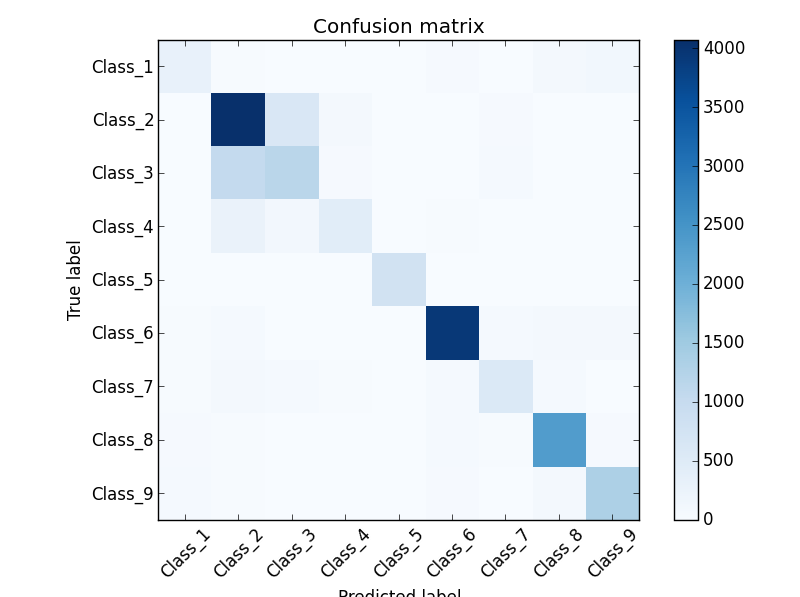

In [85]:
from IPython.core.display import Image 
Image(filename='C:/Users/acelikkaya/D&A/First Steps/confusionmatrix_RF_80percent_21082015.png') 

## Hyperparameter optimization with GridSearchCV & RandomizedSearchCV
## (for Unsampled)

In [34]:
#Random Forest works best with sqrt(#features) according to different sources
sqrtfeat = np.sqrt(x_final.shape[1]) #need int, sqrt generates float. round and cast to int64
sqrtfeat = np.int64(np.round(sqrtfeat))
sqrtfeat

10

In [68]:
# use a full grid over all parameters WITH NUMBER TREES
param_grid_ManyTrees = {
              "class_weight": ["auto", "subsample", None], 
              "n_estimators": [200,500,1000],
              "max_depth": [3, None],
              "max_features": [10, 30],
              "min_samples_split": [3, 10, 15],
              "min_samples_leaf": [3, 10, 15],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
#max features with sqrt and log2 was bad. return to fix number like above on top of code.

# Utility function to report best scores
def report(grid_scores, n_top=5):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [69]:
#RandomizedSearchCV optimizing 
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint

n_iter_search = 30
random_search = RandomizedSearchCV(rf_weighted, param_distributions=param_grid_ManyTrees,
                                   n_iter=n_iter_search, cv=3)

start = time()
random_search.fit(Xbal_train, ybal_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.grid_scores_)

#my TODOs:
#try again with 300 instead of 100 trees, re-introduce sqrtfeat as maxfeature.
#try to exclude/include more informative features by finding

RandomizedSearchCV took 676.51 seconds for 30 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.760 (std: 0.003)
Parameters: {'criterion': 'entropy', 'n_estimators': 500, 'bootstrap': False, 'min_samples_split': 10, 'max_features': 10, 'min_samples_leaf': 3, 'max_depth': None, 'class_weight': 'auto'}

Model with rank: 2
Mean validation score: 0.754 (std: 0.006)
Parameters: {'criterion': 'gini', 'n_estimators': 200, 'bootstrap': False, 'min_samples_split': 3, 'max_features': 30, 'min_samples_leaf': 3, 'max_depth': None, 'class_weight': 'subsample'}

Model with rank: 3
Mean validation score: 0.749 (std: 0.003)
Parameters: {'criterion': 'entropy', 'n_estimators': 1000, 'bootstrap': True, 'min_samples_split': 10, 'max_features': 30, 'min_samples_leaf': 3, 'max_depth': None, 'class_weight': 'subsample'}

Model with rank: 4
Mean validation score: 0.748 (std: 0.005)
Parameters: {'criterion': 'gini', 'n_estimators': 1000, 'bootstrap': True, 'min_samples_split': 15, 'ma

In [46]:
#GridSearchCV hyperparameter optimizing
grid_search = GridSearchCV(rf1, param_grid=param_grid_ManyTrees) #add cv=kfold??
start = time()
grid_search.fit(Xtrain_class2, ytrain_class2)
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

KeyboardInterrupt: 

In [37]:
#This code is a helper to Un-code the LabelEncoded Classtargets from x_total (estimator for all classes)
#This function might be not needed, if labelencoder is saved in a var before encoding like this:

def uncode_classes(prediction):
    if prediction==0:
        return "Class_1"
    elif prediction==1:
        return "Class_5"
    elif prediction==2:
        return "Class_6"
    elif prediction==3:
        return "Class_7"
    elif prediction==4:
        return "Class_8"
    elif prediction==5:
        return "Class_9"
    elif prediction==6:
        return "Class 2,3,4"

# 2. part: Classification with sampled data
## Import Data (Kaggle OTTO challenge, SAMPLED)
[**Explanation**]: The original training dataset from the challenge is unbalanced to some degree. we want to explore, if there is room to optimize the classification results by undersampling the training dataset. For this, _RUS - Random Majority Undersampling_ is being applied to balance the data. The reason for choosing RUS is, that it is simple and there is some scientific work, that proposes RUS as a good choice* for Random Forest:

_"Overall, however, RUS resulted in very good performance, being the best sampling tech-nique 748 of 2340 times."_

*_(source: VAN HULSE, Jason; KHOSHGOFTAAR, Taghi M.; NAPOLITANO, Amri. Experimental perspectives on learning from imbalanced data. In: Proceedings of the 24th international conference on Machine learning. ACM, 2007. S. 935-942.)_

In [48]:
#Step1: Read raw data, split up samples and concatenate to new resultframe
x_raw = pd.read_csv("./data/train.csv")
df1 = x_raw.copy()

df_sorted=df1.sort(columns=['target'], inplace=True)
# set the index to be this and don't drop
df1.set_index(keys=['target'], drop=False,inplace=True)

df_class1 = df1.loc[df1.target=="Class_1"] #1929 samples actually
df_class2 = df1.loc[df1.target=="Class_2"].sample(2000)
df_class3 = df1.loc[df1.target=="Class_3"].sample(2000)
df_class4 = df1.loc[df1.target=="Class_4"].sample(2000)
df_class5 = df1.loc[df1.target=="Class_5"].sample(2000)
df_class6 = df1.loc[df1.target=="Class_6"].sample(2000)
df_class7 = df1.loc[df1.target=="Class_7"].sample(2000)
df_class8 = df1.loc[df1.target=="Class_8"].sample(2000)
df_class9 = df1.loc[df1.target=="Class_9"].sample(2000)

frames = [df_class1, df_class2, df_class3, 
          df_class4, df_class5, df_class6,
          df_class7, df_class8, df_class9]
result = pd.concat(frames)
x_balanced = result.iloc[np.random.permutation(len(result))] #reshuffle dataset
#result_shuffled.shape
#indizes neu setzen zu erst!!! ANFANG:
x_balanced.reset_index(drop=True)


x_balanced = x_balanced.drop('id',axis=1) #axis1 ist glaube ich die y-achse, also columns...
y_balanced = x_balanced.target.values
y_balanced = LabelEncoder().fit_transform(y_balanced) #binarize labels
x_balanced = x_balanced.drop('target', axis=1)

In [49]:
#Step2: After loading dataset, split data
Xbal_train, Xbal_test, ybal_train, ybal_test = train_test_split(x_balanced, y_balanced, test_size=0.3, random_state=0)

In [50]:
#Step3: Choose CV iterator
from sklearn import cross_validation
k_fold = cross_validation.KFold(len(x_balanced), n_folds=5, shuffle=True)
for train_indices, test_indices in k_fold:
     print('Train: %s | test: %s' % (train_indices, test_indices))

Train: [    0     1     2 ..., 17924 17925 17928] | test: [   11    17    24 ..., 17922 17926 17927]
Train: [    2     3     4 ..., 17926 17927 17928] | test: [    0     1     8 ..., 17909 17910 17916]
Train: [    0     1     2 ..., 17926 17927 17928] | test: [    4    16    23 ..., 17914 17921 17923]
Train: [    0     1     4 ..., 17924 17926 17927] | test: [    2     3     5 ..., 17917 17925 17928]
Train: [    0     1     2 ..., 17926 17927 17928] | test: [   19    31    37 ..., 17911 17915 17924]


In [60]:
#Step4: Choose estimator, RF in our case.
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10,n_jobs=-1)
rf_noweight = RandomForestClassifier(n_estimators=300, max_features="sqrt", criterion="gini", bootstrap=False,
                                min_samples_leaf=1, min_samples_split=3, max_depth= None,
                                n_jobs=-1)

rf_weighted = RandomForestClassifier(n_estimators=1500, max_features="sqrt", criterion="gini", bootstrap=False,
                                min_samples_leaf=1, min_samples_split=3, max_depth= None, class_weight="subsample",
                                n_jobs=-1)

In [61]:
#Step5: K Prediction Scores for k-folds
[rf_weighted.fit(Xbal_train, ybal_train).score(Xbal_test, ybal_test)
         for train, test in k_fold]

[0.77988473693995164,
 0.77802565532626877,
 0.77858337981037362,
 0.77988473693995164,
 0.78137200223089798]

In [78]:
#clf = RandomForestClassifier(n_estimators=250, n_jobs=-1)
# in our case, 'isotonic' works better than default 'sigmoid'
calibrated_clf = CalibratedClassifierCV(rf_weighted, method='isotonic', cv=5)
calibrated_clf.fit(Xbal_train, ybal_train)
ypreds = calibrated_clf.predict_proba(Xbal_test)


In [79]:
print ("%.2f" % log_loss(ybal_test, ypreds, eps=1e-15, normalize=True))

0.63


In [81]:
predicted_calib = calibrated_clf.predict(Xbal_test)

In [62]:
predicted_xbal = rf_weighted.predict(Xbal_test)

In [82]:
confusion_matrix(ybal_test, predicted_calib)

array([[407,   5,   9,   2,   2,  18,  49,  42,  72],
       [  1, 385, 159,  63,   5,   0,  18,   0,   2],
       [  1, 101, 376,  85,   0,   0,  33,   0,   2],
       [  0,  40,  87, 431,   2,  13,  18,   0,   2],
       [  2,   4,   5,   3, 586,   1,   3,   0,   0],
       [ 16,   3,   2,   5,   0, 490,  35,   8,  20],
       [ 23,   9,  28,  18,   2,  13, 491,  14,   3],
       [ 34,   1,   5,   0,   0,  12,  12, 533,  10],
       [ 47,   1,   0,   1,   2,  14,   7,  18, 468]])

In [64]:
from sklearn.metrics import confusion_matrix
confusion_matrix(ybal_test, predicted_xbal)

array([[423,   4,   8,   2,   2,  16,  37,  39,  75],
       [  2, 403, 146,  60,   6,   0,  14,   0,   2],
       [  1, 109, 372,  87,   0,   0,  26,   1,   2],
       [  0,  48,  81, 435,   1,  12,  14,   0,   2],
       [  1,   5,   4,   3, 588,   1,   2,   0,   0],
       [ 19,   4,   2,   5,   0, 492,  30,   7,  20],
       [ 23,  14,  28,  20,   2,  12, 487,  12,   3],
       [ 41,   1,   5,   0,   0,  11,  12, 526,  11],
       [ 39,   0,   0,   1,   2,  14,   7,  18, 477]])

In [65]:
print(classification_report(ybal_test, predicted_xbal, target_names=otto_target_names))

             precision    recall  f1-score   support

    Class_1       0.77      0.70      0.73       606
    Class_2       0.69      0.64      0.66       633
    Class_3       0.58      0.62      0.60       598
    Class_4       0.71      0.73      0.72       593
    Class_5       0.98      0.97      0.98       604
    Class_6       0.88      0.85      0.87       579
    Class_7       0.77      0.81      0.79       601
    Class_8       0.87      0.87      0.87       607
    Class_9       0.81      0.85      0.83       558

avg / total       0.78      0.78      0.78      5379



In [83]:
print(classification_report(ybal_test, predicted_calib, target_names=otto_target_names))

             precision    recall  f1-score   support

    Class_1       0.77      0.67      0.72       606
    Class_2       0.70      0.61      0.65       633
    Class_3       0.56      0.63      0.59       598
    Class_4       0.71      0.73      0.72       593
    Class_5       0.98      0.97      0.97       604
    Class_6       0.87      0.85      0.86       579
    Class_7       0.74      0.82      0.78       601
    Class_8       0.87      0.88      0.87       607
    Class_9       0.81      0.84      0.82       558

avg / total       0.78      0.77      0.77      5379



In [84]:
#Plotting of the confusion matrix via matplotlib (matlab-style)
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(otto_target_names))
    plt.xticks(tick_marks, otto_target_names, rotation=45)
    plt.yticks(tick_marks, otto_target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cm = confusion_matrix(ybal_test, predicted_calib)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

plt.show()

Confusion matrix, without normalization
[[407   5   9   2   2  18  49  42  72]
 [  1 385 159  63   5   0  18   0   2]
 [  1 101 376  85   0   0  33   0   2]
 [  0  40  87 431   2  13  18   0   2]
 [  2   4   5   3 586   1   3   0   0]
 [ 16   3   2   5   0 490  35   8  20]
 [ 23   9  28  18   2  13 491  14   3]
 [ 34   1   5   0   0  12  12 533  10]
 [ 47   1   0   1   2  14   7  18 468]]


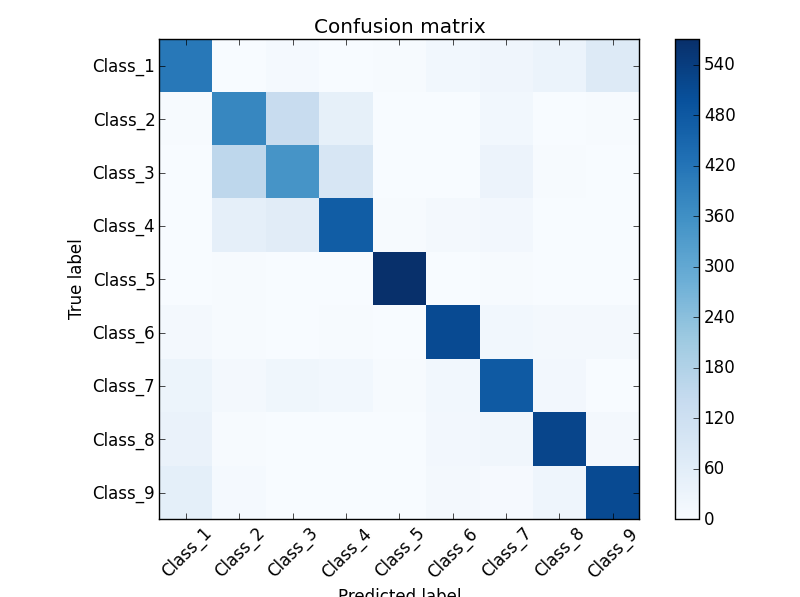

In [86]:
Image(filename='C:/Users/acelikkaya/D&A/First Steps/confus_matrix_RUS_sampled_26082015.png') 

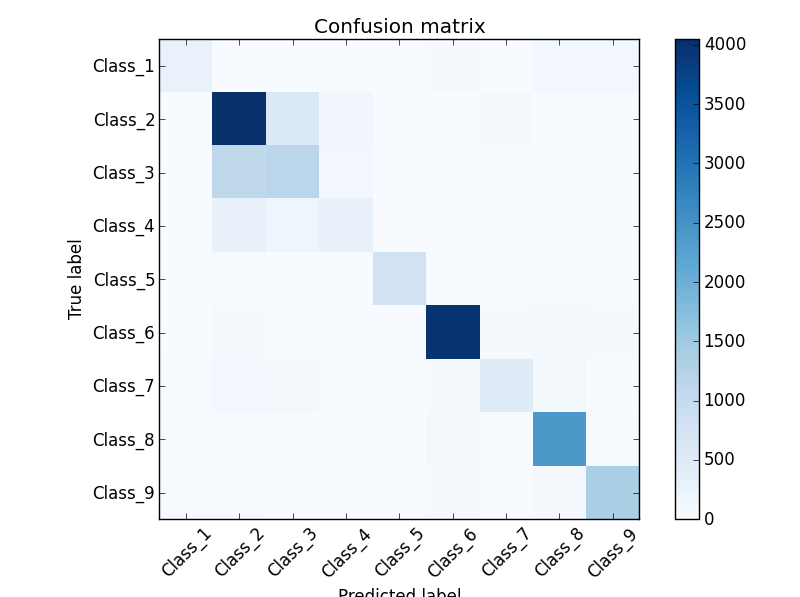

In [87]:
Image(filename='C:/Users/acelikkaya/D&A/First Steps/confus_matrix_NOT_sampled_STACKED_30percenttestsplit_04092015.png') 


## Learning Curve plots

[**Explanation**]: Plotting of n_estimators against pred.error or pred.acc.

In [30]:
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve
import pylab
plt.title("Random Forest Tree-Size / Pred.Acc.")
plt.grid() 


In [31]:
rf_10 = RandomForestClassifier(n_estimators=10, max_features="sqrt", criterion="gini", bootstrap=False,
                                min_samples_leaf=1, min_samples_split=3, max_depth= None, class_weight="auto",
                                n_jobs=-1)
rf_25 = RandomForestClassifier(n_estimators=25, max_features="sqrt", criterion="gini", bootstrap=False,
                                min_samples_leaf=1, min_samples_split=3, max_depth= None, class_weight="auto",
                                n_jobs=-1)
rf_50 = RandomForestClassifier(n_estimators=50, max_features="sqrt", criterion="gini", bootstrap=False,
                                min_samples_leaf=1, min_samples_split=3, max_depth= None, class_weight="auto",
                                n_jobs=-1)
rf_100 = RandomForestClassifier(n_estimators=100, max_features="sqrt", criterion="gini", bootstrap=False,
                                min_samples_leaf=1, min_samples_split=3, max_depth= None, class_weight="auto",
                                n_jobs=-1)
rf_150 = RandomForestClassifier(n_estimators=150, max_features="sqrt", criterion="gini", bootstrap=False,
                                min_samples_leaf=1, min_samples_split=3, max_depth= None, class_weight="auto",
                                n_jobs=-1)
rf_200 = RandomForestClassifier(n_estimators=200, max_features="sqrt", criterion="gini", bootstrap=False,
                                min_samples_leaf=1, min_samples_split=3, max_depth= None, class_weight="auto",
                                n_jobs=-1)
rf_250 = RandomForestClassifier(n_estimators=250, max_features="sqrt", criterion="gini", bootstrap=False,
                                min_samples_leaf=1, min_samples_split=3, max_depth= None, class_weight="auto",
                                n_jobs=-1)
rf_300 = RandomForestClassifier(n_estimators=300, max_features="sqrt", criterion="gini", bootstrap=False,
                                min_samples_leaf=1, min_samples_split=3, max_depth= None, class_weight="auto",
                                n_jobs=-1)
rf_400 = RandomForestClassifier(n_estimators=400, max_features="sqrt", criterion="gini", bootstrap=False,
                                min_samples_leaf=1, min_samples_split=3, max_depth= None, class_weight="auto",
                                n_jobs=-1)
rf_500 = RandomForestClassifier(n_estimators=500, max_features="sqrt", criterion="gini", bootstrap=False,
                                min_samples_leaf=1, min_samples_split=3, max_depth= None, class_weight="auto",
                                n_jobs=-1)  

In [32]:
#pred_array = np.array([])
#pred_array = []
#pred_array=np.append(pred_array,3)

tree_array = [10,25,50,100,150,200,250,300,400,500]
#tree_array
#pred_array
#reversed_arr = pred_array[::-1]
#reversed_arr

In [36]:
pred_array = []
for i, clf in enumerate((rf_10, rf_25, rf_50, rf_100, rf_150, rf_200, rf_250, rf_300, rf_400, rf_500)):
    pred_array = np.append(pred_array, clf.fit(Xbal_train, ybal_train).score(Xbal_test, ybal_test))

In [37]:
pylab.plot(tree_array, pred_array)
pylab.xlabel("Number of Trees")
pylab.ylabel("Prediction Score")
pylab.grid()

pylab.show()

## Hyperparameter optimization with GridSearchCV & RandomizedSearchCV

In [39]:
#Random Forest works best with sqrt(#features) according to different sources
sqrtfeat = np.sqrt(x_balanced.shape[1]) #need int, sqrt generates float. round and cast to int64
sqrtfeat = np.int64(np.round(sqrtfeat))
sqrtfeat

10

In [42]:
# use a full grid over all parameters WITH NUMBER TREES
param_grid_ManyTrees = {
              "class_weight": ["auto", "subsample", None], 
              "n_estimators": [100,200,500],
              "max_depth": [3, None],
              "max_features": [10, 30],
              "min_samples_split": [2, 3, 10, 15],
              "min_samples_leaf": [2, 3, 10, 15],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
#max features with sqrt and log2 was bad. return to fix number like above on top of code.

# Utility function to report best scores
def report(grid_scores, n_top=5):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [43]:
#RandomizedSearchCV optimizing 
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint

n_iter_search = 30
random_search = RandomizedSearchCV(rf_weighted, param_distributions=param_grid_ManyTrees,
                                   n_iter=n_iter_search, cv=3)

start = time()
random_search.fit(Xbal_train, ybal_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.grid_scores_)

#my TODOs:
#try again with 300 instead of 100 trees, re-introduce sqrtfeat as maxfeature.
#try to exclude/include more informative features by finding

RandomizedSearchCV took 103.04 seconds for 30 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.759 (std: 0.003)
Parameters: {'class_weight': 'auto', 'min_samples_leaf': 3, 'bootstrap': False, 'n_estimators': 100, 'min_samples_split': 2, 'max_depth': None, 'max_features': 10, 'criterion': 'gini'}

Model with rank: 2
Mean validation score: 0.743 (std: 0.007)
Parameters: {'class_weight': None, 'min_samples_leaf': 3, 'bootstrap': False, 'n_estimators': 100, 'min_samples_split': 2, 'max_depth': None, 'max_features': 30, 'criterion': 'gini'}

Model with rank: 3
Mean validation score: 0.729 (std: 0.007)
Parameters: {'class_weight': 'subsample', 'min_samples_leaf': 2, 'bootstrap': False, 'n_estimators': 10, 'min_samples_split': 15, 'max_depth': None, 'max_features': 10, 'criterion': 'gini'}

Model with rank: 4
Mean validation score: 0.725 (std: 0.007)
Parameters: {'class_weight': 'subsample', 'min_samples_leaf': 2, 'bootstrap': False, 'n_estimators': 50, 'min_samples_

In [45]:
#GridSearchCV hyperparameter optimizing
grid_search = GridSearchCV(rf_weighted, param_grid=param_grid_ManyTrees) #add cv=kfold??
start = time()
grid_search.fit(Xbal_train, ybal_train)
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

KeyboardInterrupt: 

TypeError: unhashable type: 'slice'

## Testing area only here (not for final solution)--------------------------------------------------------------

In [ ]:
testlist = rf_all.predict_proba(Xtest_total.iloc[[11900]])
#testlist = np.delete(testlist, testlist.argmax())
testlist = np.delete(testlist, testlist.argmax())

le_y_test.inverse_transform(testlist.argmax())

ytest_total[11900]

#%timeit stack_estimate(x_total,12111)
stack_estimate(Xtest_index, 11900)

rf_all.predict(Xtest_index.iloc[[1900]])

y_tottest_index[11888]

#### _(deprecated) Uncode function to translate back to original labels_

#### (TODO) Establish scikit pipeline

In [20]:
from sklearn.pipeline import Pipeline
estimators = [('rfclass2', RandomForestClassifier()), ('rfclass3', RandomForestClassifier()),
              ('rfclass4', RandomForestClassifier()), ('rfrest', RandomForestClassifier())]
clf = Pipeline(estimators) 
clf.set_params(rfrest__n_estimators=100)

Pipeline(steps=[('rfclass2', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])